# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [1]:
import sys
sys.path.append('../')

import lib.utils as utils
#import classes
import matplotlib.pyplot as plt
import igraph as g
import json
import math as m
import cv2
import itertools
import igraph

import lib.graphLib.graph as g
from lib.graphLib.vertex import Vertex
from lib.graphLib.edge import Edge
import lib.graphLib.subisomorphismAlgorithm as algorithm

import lib.graphProcessing as graphProcessing

from lib.utils import getPixel,colorPixels,isOneColor
from lib.constants import *

C:\Users\Markus Mayrhofer\AppData\Local\Programs\Python\Python39\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e
  warnings.warn(msg, RuntimeWarning)


In [2]:
imageArray = utils.load1Pixel("./../resources/testImages","preprocessed5.png",binary=True)
colorImage = utils.load1Pixel("./../resources/testImages","preprocessed5.png",color=True)

end reached


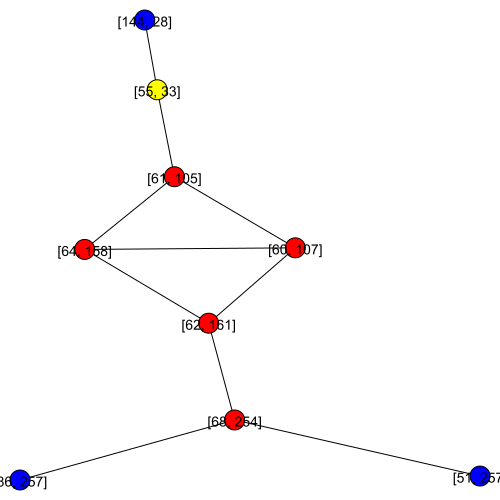

In [3]:
# Returns all Adjacent Pixels with a specific color
# image             -> 2D array with Pixel values
# pixel             -> coordinates of the pixel the others should be ajacent to
# color             -> the color of the "wanted" pixels
# blacklist         -> These pixels get ignored
def getAdjacentPixel(image,pixel,color,blacklist=[]):    
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    #create a array with the coordinates of all adjacentPixels
    validPixels = ([ pixel[0]+adj[0], pixel[1]+adj[1] ] for adj in adjacentPixels)
    #filter all pixels that are not the right color
    validPixels = list(
        filter(lambda coords: getPixel(image,coords) == color,validPixels)
    )
    #filter all pixels that are in the blacklist
    validPixels = list(
        filter(lambda x: not x in blacklist, validPixels)
    )

    return validPixels

# returns the coordinates of the first <color> pixel it finds
def findStaringPoint(image,color):
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            if getPixel(image,x,y) == color:
                return [x,y]

# Runs along line until it finds the first Intersection
#
# image      -> The image
# startPoint -> Any random Point on the line
# color      -> The color of the Line
def findFirstIntersection(image,startPoint,color):

    def recursiveFindValidPoint(currentPixel,lastPixel,dir):
        adjacentPixels = getAdjacentPixel(image,currentPixel,color)
        if len(adjacentPixels) > 2:
            return currentPixel
        elif len(adjacentPixels) == 1:
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,-1)
        else:
            adjacentPixels = getAdjacentPixel(image,currentPixel,color,[lastPixel]) 
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,dir)
    return recursiveFindValidPoint(startPoint,None,0)

# Converts one connected Line into a Graph
#
# startPoint  -> coordinates of a Intersection
# color -> the color of the lines
# returns the generate graph and all visited Pixels
def generatePartGraph(image,startPoint,color):
    visitedPixels = []
    #graph = g.Graph(directed=False)
    #graph.add_vertex(str(startPoint), label=str(startPoint) ,color=INTERSECTION_COLOR)
    graph = g.Graph()

    vertex = Vertex(color=INTERSECTION_COLOR, label=str(startPoint))
    vertex.attr["coordinates"] = startPoint
    graph.addVertex(vertex)
    
    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode,dirGradientOld):
        dirGradient = list(dirGradientOld)

        #get Direction
        xDir = 0
        yDir = 0

        if currentPixel[0] - lastPixel[0] > 0:
            xDir = 1
        elif currentPixel[0] - lastPixel[0] < 0:
            xDir = -1

        if currentPixel[1] - lastPixel[1] > 0:
            yDir = 1
        elif currentPixel[1] - lastPixel[1] < 0:
            yDir = -1

        dirGradient.append((xDir,yDir))


        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            #if len(graph.vs.select(name=str(currentPixel))):
            #    graph.add_edge(str(lastGraphNode),str(currentPixel))
            if len(graph.verticesWithLabel(str(currentPixel))):
                edge = Edge()
                v1 = graph.verticesWithLabel(str(lastGraphNode))[0]
                v2 = graph.verticesWithLabel(str(currentPixel))[0]
                graph.addEdge(edge,v1.id,v2.id)
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,color,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                #graph.add_vertex(str(currentPixel),label=str(currentPixel),color=END_COLOR)
                #graph.add_edge(str(lastGraphNode),str(currentPixel))
                vertex = Vertex(color=END_COLOR, label=str(currentPixel))
                vertex.attr["coordinates"] = currentPixel
                graph.addVertex(vertex)
                edge = Edge()
                v1 = graph.verticesWithLabel(str(lastGraphNode))[0]
                v2 = graph.verticesWithLabel(str(currentPixel))[0]
                graph.addEdge(edge,v1.id,v2.id)

        elif len(adjacentPixels) == 1:
            #LINE
            if len(dirGradient) >= 10:
                currDir = [sum(x) for x in zip(*dirGradient[-5:])]
                length = m.sqrt(currDir[0]**2 + currDir[1]**2)
                currDir = (currDir[0]/length, currDir[1]/length)

                
                lastDir = [sum(x) for x in zip(*dirGradient[-10:-5])]
                length = m.sqrt(lastDir[0]**2 + lastDir[1]**2)
                lastDir = (lastDir[0]/length, lastDir[1]/length)

                dist = m.sqrt((currDir[0] - lastDir[0])**2 + (currDir[1] - lastDir[1])**2)

                if dist > 0.8:
                    #graph.add_vertex(str(currentPixel),label=str(currentPixel),color=CORNER_COLOR)
                    #graph.add_edge(str(lastGraphNode),str(currentPixel))
                    vertex = Vertex(color=CORNER_COLOR, label=str(currentPixel))
                    vertex.attr["coordinates"] = currentPixel
                    graph.addVertex(vertex)
                    edge = Edge()
                    v1 = graph.verticesWithLabel(str(lastGraphNode))[0]
                    v2 = graph.verticesWithLabel(str(currentPixel))[0]
                    graph.addEdge(edge,v1.id,v2.id)
                    dirGradient = []
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,str(currentPixel),dirGradient)
                else:
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
            else:
                recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                #graph.add_vertex(str(currentPixel),label=str(currentPixel),color=INTERSECTION_COLOR)
                #graph.add_edge(str(lastGraphNode),str(currentPixel))
                vertex = Vertex(color=INTERSECTION_COLOR, label=str(currentPixel))
                vertex.attr["coordinates"] = currentPixel
                graph.addVertex(vertex)
                edge = Edge()
                v1 = graph.verticesWithLabel(str(lastGraphNode))[0]
                v2 = graph.verticesWithLabel(str(currentPixel))[0]
                graph.addEdge(edge,v1.id,v2.id)
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel),[])

    recursiveGenerateGraph(startPoint,[0,0],str(startPoint),[])
    return graph,visitedPixels


def generateWholeGraph(image,foregroundColor,backgroundColor):
    graphCollection = []
    while True:
        startingPoint = findStaringPoint(image,foregroundColor)
        if(startingPoint):
            startingPoint = findFirstIntersection(image,startingPoint,foregroundColor)
            G,visitedPixels = generatePartGraph(image,startingPoint,foregroundColor)
            graphCollection.append(G)
            #Remove all visited Pixels
            image = colorPixels(image,visitedPixels,backgroundColor)
            if isOneColor(image,backgroundColor):
                print("end reached")
                break
        else:
            print("stoped before end")
            break
    return g.union(graphCollection)
    #return graphCollection

union = generateWholeGraph(imageArray,FOREGROUND,BACKGROUND)

igraphUnion = utils.convertToIgraph(union)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (500,500))

### Graph Preprocessing

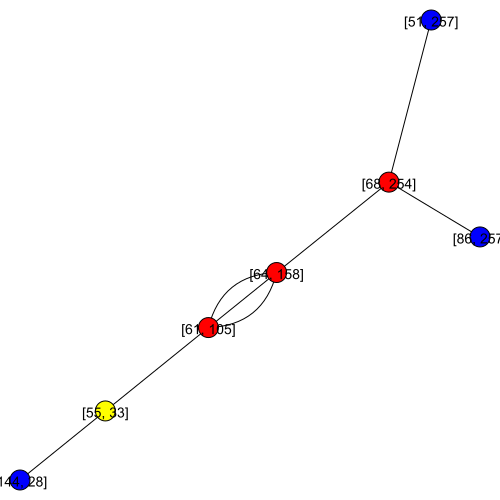

In [4]:
#combine close tougether vertices
allVertices = list(union.ve.values())

#intersectionVertices
intersectionVertices = list(filter(lambda x: x.color == INTERSECTION_COLOR,allVertices))

union = graphProcessing.combineCloseVertices(union,intersectionVertices,INTERSECTION_COMBINATION_DIST)

igraphUnion = utils.convertToIgraph(union)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (500,500))

#### Pattern detection

In [5]:
def groundPattern():
    ground = g.Graph()
    v1 = Vertex(color="blue")
    v2 = Vertex(color="red")
    v3 = Vertex(color="blue")
    ground.addVertex(v1)
    ground.addVertex(v2)
    ground.addVertex(v3)
    ground.addEdge(Edge(), v1.id, v2.id)
    ground.addEdge(Edge(), v3.id, v2.id)

    return ground

def getColorListNode(graph):
    colorList = []
    for vert in graph.ve:
        if vert.color == "red":
            colorList.append(0)
        elif vert.color == "blue":
            colorList.append(1)
        elif vert.color == "yellow":
            colorList.append(2)
        elif vert.color == "white":
            colorList.append(3)
    return colorList

def getColorListEdge(graph):
    colorList = []
    for edge in graph.ed:
        try:
            if edge.color == "red":
                colorList.append(1)
            elif edge.color == "blue":
                colorList.append(2)
            elif edge.color == "yellow":
                colorList.append(3)
            elif edge.color == "white":
                colorList.append(4)
            elif edge.color == "green":
                colorList.append(5)
            else:
                colorList.append(0)
        except:
            colorList.append(0)
    return colorList

def getPatternMatches(graph,pattern):
    mapings = algorithm.subisomorphism(graph, pattern)

    mapings = list(map(lambda match: set(match), mapings))

    
    #remove duplicated
    final = []
    for i in mapings:
        if i not in final:
            final.append(i)
    return list(map(lambda f: list(f), final))

def connectCapsTogehter(graph):
    groundGraph = groundPattern()

    # Match all ground Symbols
    groundMatches = getPatternMatches(graph,groundGraph)

    up = []
    down = []
    left = []
    right = []
    for groundMatchVertices in groundMatches:

        intersectionVertex = None
        for match in groundMatchVertices:
            if match.color == INTERSECTION_COLOR:
                intersectionVertex = match

        neighborVertices = graph.getNeighbors(intersectionVertex.id)

        for neighborVertex in neighborVertices:
            if not neighborVertex.color == 'blue':

                xOff = intersectionVertex.attr['coordinates'][0] - neighborVertex.attr['coordinates'][0]
                yOff = intersectionVertex.attr['coordinates'][1] - neighborVertex.attr['coordinates'][1]

                if abs(xOff) > abs(yOff):
                    if xOff > 0:
                        left.append(intersectionVertex)
                    else:
                        right.append(intersectionVertex)
                else:
                    if yOff > 0:
                        up.append(intersectionVertex)
                    else:
                        down.append(intersectionVertex)
                break


    for lCap in left:
        lCoord = lCap.attr['coordinates']

        rCoord = right[0].attr['coordinates']
        minDist = m.hypot(lCoord[0]-rCoord[0], lCoord[1]-rCoord[1])
        minCap = right[0]

        for rCap in right:
            rCoord = rCap.attr['coordinates']
            dist = m.hypot(lCoord[0]-rCoord[0], lCoord[1]-rCoord[1])

            if dist < minDist and graph.adjacent(lCap.id, rCap.id) == False:
                minDist = dist
                minCap = rCap

        lCap.color = OTHER_NODE_COLOR
        minCap.color = OTHER_NODE_COLOR
        graph.addEdge(Edge(color=OTHER_EDGE_COLOR),lCap.id, minCap.id)

    for dCap in down:
        dCoord = dCap.attr['coordinates']

        uCoord = up[0].attr['coordinates']
        minDist = m.hypot(dCoord[0]-uCoord[0], dCoord[1]-uCoord[1])
        minCap = up[0]

        for uCap in up:
            uCoord = uCap.attr['coordinates']
            dist = m.hypot(dCoord[0]-uCoord[0], dCoord[1]-uCoord[1])

            if dist < minDist and graph.adjacent(dCap.id, uCap.id) == False:
                minDist = dist
                minCap = uCap

        dCap.color = OTHER_NODE_COLOR
        minCap.color = OTHER_NODE_COLOR
        graph.addEdge(Edge(color=OTHER_EDGE_COLOR),dCap.id, minCap.id)

    return graph

def capPattern():
    cap = g.Graph()
    v1 = Vertex(color="blue")
    v2 = Vertex(color="white")
    v3 = Vertex(color="blue")
    cap.addVertices([v1,v2,v3])
    cap.addEdge(Edge(), v1.id, v2.id)
    cap.addEdge(Edge(), v3.id, v2.id)

    v4 = Vertex(color="blue")
    v5 = Vertex(color="white")
    v6 = Vertex(color="blue")
    cap.addVertices([v4,v5,v6])
    cap.addEdge(Edge(), v4.id, v5.id)
    cap.addEdge(Edge(), v6.id, v5.id)

    cap.addEdge(Edge(color="green"), v2.id, v5.id)
    return cap

def resistorPattern():
    res = g.Graph()
    v1 = Vertex(color="red")
    v2 = Vertex(color="yellow")
    v3 = Vertex(color="yellow")
    v4 = Vertex(color="red")
    v5 = Vertex(color="yellow")
    v6 = Vertex(color="yellow")
    res.addVertices([v1,v2,v3,v4,v5,v6])
    res.addEdge(Edge(), v1.id, v2.id)
    res.addEdge(Edge(), v2.id, v3.id)
    res.addEdge(Edge(), v3.id, v4.id)
    res.addEdge(Edge(), v4.id, v5.id)
    res.addEdge(Edge(), v5.id, v6.id)
    res.addEdge(Edge(), v6.id, v1.id)
    
    return res

In [6]:
union = connectCapsTogehter(union)

igraphUnion = utils.convertToIgraph(union)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (1000,1000))

AttributeError: 'list' object has no attribute 'color'

In [ ]:
def generateBoundingBox(verticesList,offset):

    listOfCoords = list(map(lambda x: x.attr['coordinates'],verticesList))

    xCoords = list(map(lambda x: x[0],listOfCoords))
    yCoords = list(map(lambda y: y[1],listOfCoords))

    #get smalles and biggest of each and create Box
    from_ = [min(xCoords)-offset,min(yCoords)-offset]
    to_ = [max(xCoords)+offset,max(yCoords)+offset]
    return [from_,to_]

matches = getPatternMatches(union,groundPattern())
print("GND")
matches += getPatternMatches(union,resistorPattern())
print("RES")
matches += getPatternMatches(union,capPattern())  
print("CAP")


boundingBoxes = list(map(lambda x: generateBoundingBox(x,5),matches))
print(boundingBoxes)

[1, 1]
[1, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[1, 0]
[1, 1]
[1, 0]
[1, 1]
[0, 1]
[1, 1]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[1, 1]
[1, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[1, 1]
[0, 1]
[1, 1]
[0, 1]
[0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1]
[1, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[1, 0]
[1, 1]
[1, 0]
[1, 1]
[0, 1]
[1, 1]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[1, 1]
[1, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 0, 0]
[1, 1]
[0, 1]
[1, 1]
[0, 1]
[0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
GND
RES
CAP
[[[46, 249], [91, 262]]]


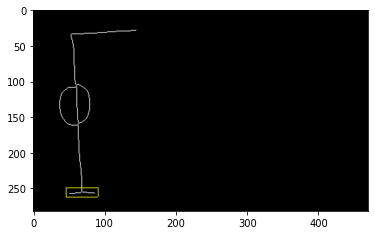

In [ ]:


def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0))
colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")